---
title: CVAE
date: 2025-02-24
---

The Variational Autoencoder (VAE) is a type of deep generative model that can learn to encode high-dimensional data, such as images, into a low-dimensional latent space and then decode that latent representation back to the original data space. A VAE is particularly useful in imaging data, as it can capture meaningful features in a compressed form, making it easier to analyze patterns, generate new images, or explore variations in the data.

**What Does a Simple VAE Do?**
* Encoder:

    The encoder maps the input image into a latent space by compressing it into a lower-dimensional representation.
    Unlike a traditional autoencoder, which might produce a fixed vector, the VAE encoder outputs two components for each latent dimension: a mean and a log variance. These parameters define a Gaussian distribution over the latent space for each input.

* Latent Space Sampling:

    After the encoder produces a mean and variance, a sample is drawn from this Gaussian distribution, which allows the VAE to introduce some randomness or variability into the latent representation.
    The sampling process makes the VAE a generative model, enabling it to create new images by sampling different points in the latent space.

* Decoder:

    The sampled latent vector is then fed to the decoder, which reconstructs the image.
    The decoder tries to reproduce the original input as accurately as possible, allowing the VAE to learn a compressed, yet informative, representation of the input data.
* Loss Function:

    The VAE optimizes two components:
    Reconstruction Loss: Measures the similarity between the input image and the reconstructed image, encouraging the VAE to accurately capture image details.
    KL Divergence: Regularizes the latent space, ensuring the learned latent distributions are close to a standard Gaussian. This keeps the latent space smooth, meaning that similar points in the latent space correspond to similar reconstructed images.

In [24]:
! pip install gdown

In [25]:
from atomai import stat as atomstat
import atomai as aoi

import numpy as np
import pyroved as pv

import torch
import random
tt = torch.tensor

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic=True
np.random.seed(0)
random.seed(0)

import os
import wget
from sklearn.preprocessing import StandardScaler
import h5py
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from skimage import feature
import skimage
from scipy.ndimage import zoom
from matplotlib.patches import Rectangle
import seaborn as sns
import ipywidgets as widgets

import ipywidgets
import pickle
from IPython.core.display import display, HTML
from ipywidgets import interact, Layout
from scipy.ndimage import zoom

/var/folders/vg/6nvxw8xn77s4z_kb5c3hz38w0000gp/T/ipykernel_16834/3107169609.py:33: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [26]:
! gdown --fuzzy --id 1AHlk5xxXiuiTtYNr8fk0YQ8Uxjbf8bfT

/Users/kbarakat/miniconda3/envs/ferro_VAE/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1AHlk5xxXiuiTtYNr8fk0YQ8Uxjbf8bfT
From (redirected): https://drive.google.com/uc?id=1AHlk5xxXiuiTtYNr8fk0YQ8Uxjbf8bfT&confirm=t&uuid=b209f9f9-bb78-4a8b-9daf-045de133bf88
To: /Users/kbarakat/Library/CloudStorage/OneDrive-UniversityofTennessee/Publications/Ferro_VAE_online/New/variational-autoencoders/notebooks/images_data.pkl
100%|████████████████████████████████████████| 480M/480M [00:29<00:00, 16.3MB/s]


In [27]:
# Load the lists from the pickle file
images_data = "images_data.pkl"

with open(images_data, "rb") as f:
    selected_images, ground_truth_px, ground_truth_py = pickle.load(f)

# Confirm successful loading by checking the lengths of the lists
print(len(selected_images), len(ground_truth_px), len(ground_truth_py))

5 5 5


In [28]:
# min-max normalization:
def norm2d(img: np.ndarray) -> np.ndarray:
    return (img - np.min(img)) / (np.max(img) - np.min(img))

In [29]:
image = selected_images[0]
img = norm2d(image)

In [30]:
def custom_extract_subimages(imgdata, coordinates, w_prime):
    # Stage 1: Extract subimages with a fixed size (64x64)
    large_window_size = (64, 64)
    half_height_large = large_window_size[0] // 2
    half_width_large = large_window_size[1] // 2
    subimages_largest = []
    coms_largest = []

    for coord in coordinates:
        cx = int(np.around(coord[0]))
        cy = int(np.around(coord[1]))
        top = max(cx - half_height_large, 0)
        bottom = min(cx + half_height_large, imgdata.shape[0])
        left = max(cy - half_width_large, 0)
        right = min(cy + half_width_large, imgdata.shape[1])

        subimage = imgdata[top:bottom, left:right]
        if subimage.shape[0] == large_window_size[0] and subimage.shape[1] == large_window_size[1]:
            subimages_largest.append(subimage)
            coms_largest.append(coord)

    # Stage 2: Use these centers to extract subimages of window size `w1`
    half_height = w_prime[0] // 2
    half_width = w_prime[1] // 2
    subimages_target = []
    coms_target = []

    for coord in coms_largest:
        cx = int(np.around(coord[0]))
        cy = int(np.around(coord[1]))
        top = max(cx - half_height, 0)
        bottom = min(cx + half_height, imgdata.shape[0])
        left = max(cy - half_width, 0)
        right = min(cy + half_width, imgdata.shape[1])

        subimage = imgdata[top:bottom, left:right]
        if subimage.shape[0] == w_prime[0] and subimage.shape[1] == w_prime[1]:
            subimages_target.append(subimage)
            coms_target.append(coord)

    return np.array(subimages_target), np.array(coms_target)

In [31]:
def build_descriptor(window_size, min_sigma, max_sigma, threshold, overlap):

    processed_img = img

    all_atoms = skimage.feature.blob_log(processed_img, min_sigma, max_sigma, 30, threshold, overlap)
    coordinates = all_atoms[:, : -1]
    # Extract subimages
    subimages_target, coms_target = custom_extract_subimages(processed_img, coordinates, window_size)
    # Build descriptors
    descriptors = [subimage.flatten() for subimage in subimages_target]
    descriptors = np.array(descriptors)

    return descriptors, coms_target, all_atoms, coordinates, subimages_target

Now we know the optimum hyperparameters 

In [32]:
window_size = (40,40)
min_sigma = 1
max_sigma = 5
threshold = 0.025
overlap = 0.0
descriptors, coms_target, all_atoms, coordinates, subimages_target = build_descriptor(window_size, min_sigma, max_sigma, threshold, overlap)

In [33]:
print(descriptors.shape)
print(coms_target.shape)
print(all_atoms.shape)
print(coordinates.shape)
print(subimages_target.shape)

(10917, 1600)
(10917, 2)
(11813, 3)
(11813, 2)
(10917, 40, 40)


However, our analysis above had a signnificant limitation. We were looking for latent representation common for A- and B-site cations, even though these are obviously different. Now, we are going to explore the conditional VAE, that consider cation type as **known** variable. Let's see how it works!

In [34]:
# Define the Fit_GMM_param function without PCA, including covariance type
def Fit_GMM(descriptors, components, covariance_type):
    # First pass of GMM to estimate initial parameters

    # Flatten each subimage into a 1D vector
    flattened_descriptors = descriptors.reshape(descriptors.shape[0], -1)
    # Remove subimages with NaN values
    mask = ~np.isnan(flattened_descriptors).any(axis=1)
    valid_subimages = flattened_descriptors[mask]

    preliminary_gmm = GaussianMixture(n_components=components, covariance_type=covariance_type, random_state=42)
    preliminary_gmm.fit(valid_subimages)
    initial_means = preliminary_gmm.means_
    initial_weights = preliminary_gmm.weights_

    # Initialize and fit the GMM using the parameters from the preliminary GMM
    gmm = GaussianMixture(n_components=components,
                          means_init=initial_means,
                          weights_init=initial_weights,
                          covariance_type=covariance_type,
                          random_state=42)

    gmm.fit(valid_subimages)

    # Map the labels back to the original data, including NaN-handling
    labels = gmm.predict(valid_subimages)

    full_labels = np.full(valid_subimages.shape[0], -1)
    full_labels[mask] = labels

    return labels, valid_subimages

In [35]:
w = (40,40)
min_sigma = 1
max_sigma = 5
threshold = 0.025
overlap = 0.0
descriptors_c, coms_target_c, all_atoms_c, coordinates_c, subimages_target_c = build_descriptor(w,
                                                                                                min_sigma,
                                                                                                max_sigma,
                                                                                                threshold,
                                                                                                overlap)

print(descriptors_c.shape)
print(subimages_target_c.shape)
print(coms_target_c.shape)
print(all_atoms_c.shape)
print(coordinates_c.shape)


labels_c, valid_subimages  = Fit_GMM(descriptors_c, 2, "full")
print(labels_c.shape)

(10917, 1600)
(10917, 40, 40)
(10917, 2)
(11813, 3)
(11813, 2)
(10917,)


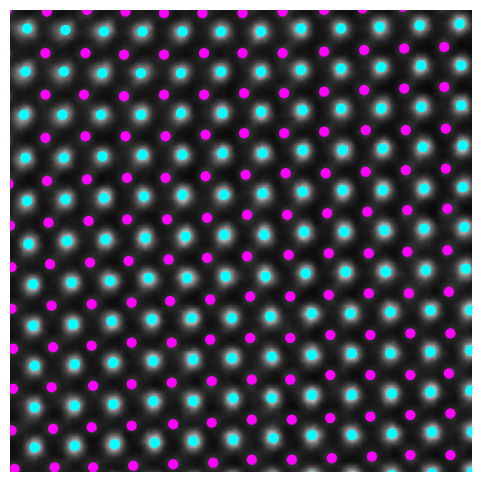

In [36]:
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.scatter(coms_target_c[:, 1], coms_target_c[:, 0], c=labels_c,  s=40, cmap='cool', marker= "o")


plt.xlim([400,700])
plt.ylim([400,700])
plt.axis('off')
plt.show()

In [37]:
subimages_target_reshaped = np.expand_dims(subimages_target, axis=-1)
train_data = torch.tensor(subimages_target_reshaped[:,:,:,0]).float()
lab_train = pv.utils.to_onehot(tt(labels_c).to(torch.int64), 2)
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), lab_train, batch_size=48)

Now, running the VAE in PyroVEd. Simple VAE will find the best representation of our data as two components for latent vecotr (l1,l2). Of course, we can explore other dimensinalities of latent space!

In [38]:
# in_dim = (window_size[0],window_size[1])

# # Initialize vanilla VAE
# Cvae = pv.models.iVAE(in_dim, latent_dim=2, c_dim = 2, # Number of latent conditions
#                      hidden_dim_e = [512, 512],
#                      hidden_dim_d = [512, 512], # corresponds to the number of neurons in the hidden layers of the decoder
#                      invariances=None, seed=0)
# # Initialize SVI trainer
# trainer = pv.trainers.SVItrainer(Cvae)

# # Train for n epochs:
# for e in range(10):
#     trainer.step(train_loader)
#     trainer.print_statistics()

# Cvae.save_weights('cvae_model')
# print("Model saved successfully.")

In [39]:
! gdown --fuzzy --id 1OvEX5tjwuTdDo6D2f14NxWpMguqY8h2P

/Users/kbarakat/miniconda3/envs/ferro_VAE/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OvEX5tjwuTdDo6D2f14NxWpMguqY8h2P
To: /Users/kbarakat/Library/CloudStorage/OneDrive-UniversityofTennessee/Publications/Ferro_VAE_online/New/variational-autoencoders/notebooks/cvae_model.pt
100%|██████████████████████████████████████| 8.69M/8.69M [00:00<00:00, 11.7MB/s]


In [ ]:
in_dim = (window_size[0],window_size[1])

# Reinitialize the model before loading weights
Cvae_model = pv.models.iVAE(in_dim, latent_dim=2, c_dim = 2, # Number of latent conditions
                     hidden_dim_e = [512, 512],
                     hidden_dim_d = [512, 512], # corresponds to the number of neurons in the hidden layers of the decoder
                     invariances=None, seed=0)

# Load the saved model weights
Cvae_model.load_weights('cvae_model.pt')

print("Model loaded successfully.")

Model loaded successfully.


/Users/kbarakat/miniconda3/envs/ferro_VAE/lib/python3.12/site-packages/pyroved/models/base.py:191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(filepat

Varitional Auto Encoder manifold representation

In [41]:
Cvae_z_mean, Cvae_z_sd = Cvae_model.encode(train_data.unsqueeze(-1), lab_train)
print('no. of defects', Cvae_z_mean.shape)

z1 = Cvae_z_mean[:, -2]
z2 = Cvae_z_mean[:, -1]

no. of defects torch.Size([10917, 2])


In [42]:
def generate_latent_manifold_C(n=10, decoder=None, target_size=(28, 28), condition=None):

    # Define grid bounds across latent space
    grid_x = np.linspace(min(z1), max(z1), n)
    grid_y = np.linspace(min(z2), max(z2), n)

    # Dynamically infer output shape
    latent_sample = torch.tensor([[grid_x[0], grid_y[0]]], dtype=torch.float32)
    if condition is not None:
        latent_sample = torch.cat((latent_sample, condition), dim=1)

    with torch.no_grad():
        X_decoded = decoder(latent_sample)

    # Check output dimensions
    if len(X_decoded.shape) == 1:
        X_decoded = X_decoded.reshape(1, -1)  # Flattened output
    output_size = X_decoded.shape[-1] if len(X_decoded.shape) == 2 else X_decoded.shape[-2:]

    # Initialize the manifold
    height, width = target_size
    manifold = np.zeros((height * n, width * n))

    # Generate the manifold grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            latent_sample = torch.tensor([[xi, yi]], dtype=torch.float32)
            if condition is not None:
                latent_sample = torch.cat((latent_sample, condition), dim=1)
            with torch.no_grad():
                X_decoded = decoder(latent_sample)
                if len(X_decoded.shape) == 1:
                    X_decoded = X_decoded.reshape(1, -1)  # Handle flattened output
            resized_image = zoom(X_decoded.numpy().reshape(output_size), 
                                 zoom=(height / output_size[0], width / output_size[1]))
            manifold[i * height: (i + 1) * height, j * width: (j + 1) * width] = resized_image

    return manifold

The latent representation of the system is visualized as a grid over the two latent variables $z_1$ and $z_2$. Each grid cell corresponds to a unique combination of values for $z_1$ and $z_2$ , which are decoded to produce corresponding reconstructions in the data space. The smooth and structured transition across the grid indicates that the model has learned a meaningful and continuous mapping between the latent variables and the data space. Variations in the grid reflect changes in the underlying physical structure, such as column type, domain orientation, or material properties.

In [43]:
def plot_CVAE():
    # Set up the figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # (a) Latent manifold for class 0
    condition_0 = torch.nn.functional.one_hot(torch.tensor([0]), num_classes=2).float()
    manifold_0 = generate_latent_manifold_C(n=10, decoder=Cvae_model.decode, target_size=(28, 28), condition=condition_0)
    axes[0].imshow(manifold_0, cmap="gnuplot2", origin="upper", aspect="auto")
    axes[0].set_xlabel(r"$z_1$", fontsize=16)
    axes[0].set_ylabel(r"$z_2$", fontsize=16)
    axes[0].set_xticks([]), axes[0].set_yticks([])
    axes[0].text(-0.05, 1, 'a)', transform=axes[0].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

    # (b) Latent manifold for class 1
    condition_1 = torch.nn.functional.one_hot(torch.tensor([1]), num_classes=2).float()
    manifold_1 = generate_latent_manifold_C(n=10, decoder=Cvae_model.decode, target_size=(28, 28), condition=condition_1)
    axes[1].imshow(manifold_1, cmap="gnuplot2", origin="upper", aspect="auto")
    axes[1].set_xlabel(r"$z_1$", fontsize=16, fontweight='bold')
    axes[1].set_ylabel(r"$z_2$", fontsize=16, fontweight='bold')
    axes[1].set_xticks([]), axes[1].set_yticks([])
    axes[1].text(-0.05, 1, 'b)', transform=axes[1].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

    # (c) Scatter plot of z1 vs z2 with KDE using sns
    sns.kdeplot(x=z1, y=z2, ax=axes[2], cmap="Oranges", levels=60, fill=True, alpha=0.7, thresh=0.005)
    sns.scatterplot(x=z1, y=z2, ax=axes[2], hue=labels_c, palette="coolwarm", s=20, edgecolor="k", alpha=0.7, legend=False)
    axes[2].set_xlabel(r"$z_1$", fontsize=16, fontweight='bold')
    axes[2].set_ylabel(r"$z_2$", fontsize=16, fontweight='bold')
    axes[2].set_xticks([]), axes[2].set_yticks([])
    axes[2].text(-0.05, 1, 'c)', transform=axes[2].transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


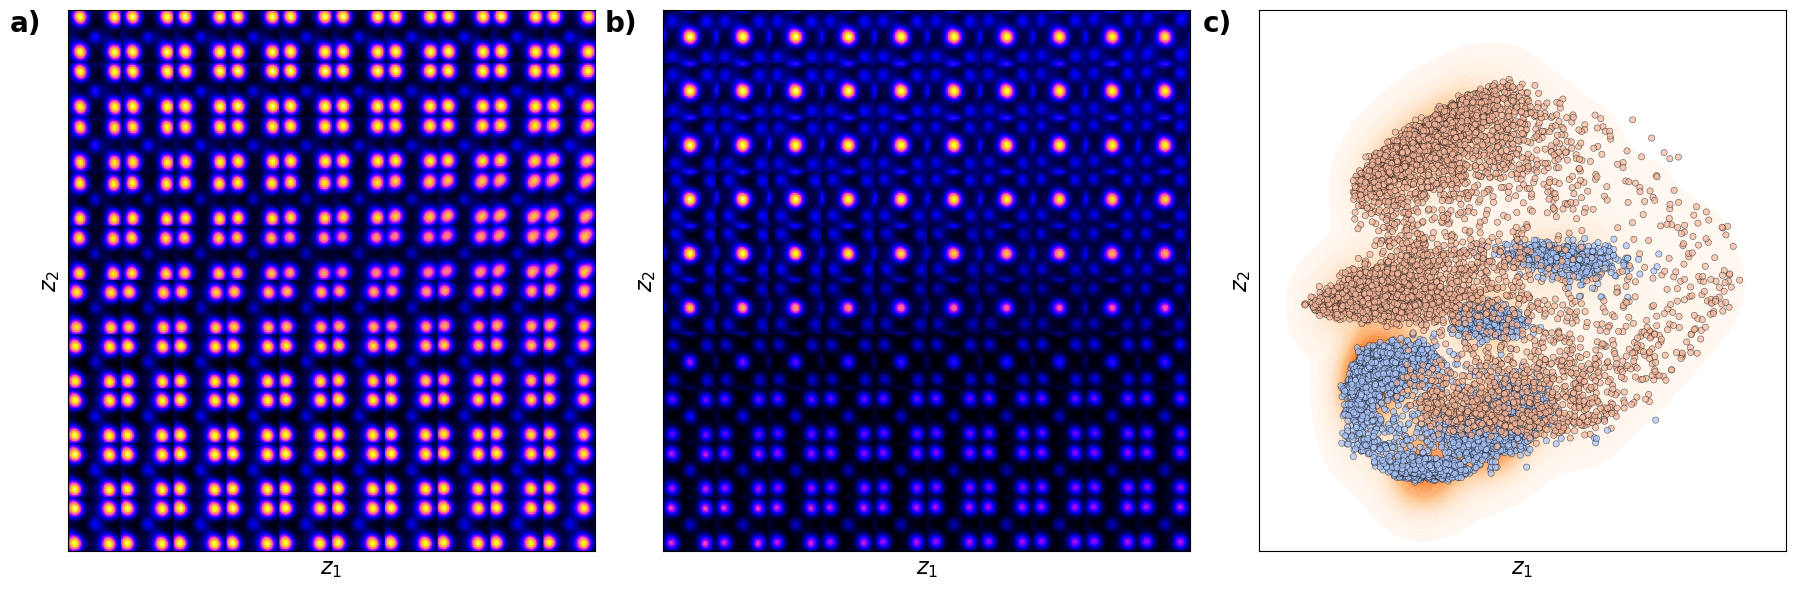

In [44]:
#| label: app:CVAE_manifold_1

plot_CVAE()

In [45]:
Px = ground_truth_px[0]
Py = ground_truth_py[0]

# List of options
options = ["z1", "z2", "Ground Truth Px", "Ground Truth Py"]

# Function to plot two selected variables
def plot_two_variables(variable1, variable2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot for variable 1
    if variable1 == "z1":
        axes[0].scatter(coms_target[:, 1], coms_target[:, 0], c=z1, s=14, cmap='jet', marker="o")
    elif variable1 == "z2":
        axes[0].scatter(coms_target[:, 1], coms_target[:, 0], c=z2, s=14, cmap='jet', marker="o")
    elif variable1 == "Ground Truth Px":
        axes[0].imshow(Px, cmap='jet', origin='lower')
    elif variable1 == "Ground Truth Py":
        axes[0].imshow(Py, cmap='jet', origin='lower')
    
    axes[0].axis("off")
    axes[0].text(-0.05, 1, 'a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

    # Plot for variable 2
    if variable2 == "z1":
        axes[1].scatter(coms_target[:, 1], coms_target[:, 0], c=z1, s=14, cmap='jet', marker="o")
    elif variable2 == "z2":
        axes[1].scatter(coms_target[:, 1], coms_target[:, 0], c=z2, s=14, cmap='jet', marker="o")
    elif variable2 == "Ground Truth Px":
        axes[1].imshow(Px, cmap='jet', origin='lower')
    elif variable2 == "Ground Truth Py":
        axes[1].imshow(Py, cmap='jet', origin='lower')
    
    axes[1].axis("off")
    axes[1].text(-0.05, 1, 'b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

    plt.tight_layout()
    plt.show()


In [ ]:
#| label: app:CVAE_latent_1


# Apply global CSS for bold labels
display(HTML("""
    <style>
        .widget-label { font-size: 16px; font-weight: bold; }
        select { font-size: 16px; font-weight: bold; }
    </style>
"""))

# Define the dropdowns with larger text
dropdown_style = {'description_width': 'initial'}
dropdown_layout = ipywidgets.Layout(width='250px')

# Create interactive widget
ipywidgets.interact(plot_two_variables, 
    variable1=ipywidgets.Dropdown(options=options, description="Variable 1", 
                               style=dropdown_style, layout=dropdown_layout),
    variable2=ipywidgets.Dropdown(options=options, description="Variable 2", 
                               style=dropdown_style, layout=dropdown_layout)
)



interactive(children=(Dropdown(description='Variable 1', layout=Layout(width='250px'), options=('z1', 'z2', 'G…

<function __main__.plot_two_variables(variable1, variable2)>